In [1]:
%matplotlib notebook

In [2]:
# imports
import numpy as np
import scipy.integrate as si
import scipy.interpolate as sip
import scipy.signal as ss
import scipy.optimize as so
import matplotlib.pyplot as plt
import dolfin
import keras
from keras.regularizers import l2

Using TensorFlow backend.


In [3]:
# fix seed
np.random.seed(1234)

# Training/validation data
Create training/validation datasets for the 
Poisson equation with (homogeneous) Neumann boundary condition:

$$ -\Delta u(x) = f(x), x \in \Omega \\
\frac{\partial u(x)}{\partial n(x)} = 0, x \in \partial \Omega \\
\Omega \in (0, 1)
$$
For simplicity of training I'll assume that $ f(x) $ is a smooth(ish) function on the domain $ \Omega $, 
and produce $n_\mathrm{samples}$ datasets for training and validation. 

In [4]:
def poisson_w_hom_neumann_1D(mesh_size=64, f='cos(pi*x[0])'):
    '''
    Solve the Poisson equation with homogeneous Neumann boundary condition
    with respect to u(x)
    
    Parameters:
    -----------
    mesh_size: int
        size of mesh
    f: str or ndarray
        if str a math expression, if ndarray a shape (mesh_size+1, ) array of floats
    
    Returns:
    --------
    u: ndarray
        solution on x
    x: ndarray
        vertex location on mesh
    
    adapted from:
    https://fenicsproject.org/docs/dolfin/1.6.0/python/demo/documented/neumann-poisson/python/documentation.html

    '''
    # Create 1D mesh
    mesh = dolfin.UnitIntervalMesh.create(mesh_size)

    # Build function space with Lagrange multiplier
    P1 = dolfin.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    R = dolfin.FiniteElement("Real", mesh.ufl_cell(), 0)
    W = dolfin.FunctionSpace(mesh, P1 * R)

    # Define variational problem
    (u, c) = dolfin.TrialFunction(W)
    (v, d) = dolfin.TestFunctions(W)

    # Coordinates on mesh:
    x = mesh.coordinates().flatten()

    # Define source function
    if type(f) is str:
        f_ = dolfin.Expression(f, degree=1)
    elif type(f) is np.ndarray:
        try:
            assert(f.shape == x.shape)
        except AssertionError:
            raise AssertionError('f must be shape (%i, )'.format(x.size))
        
        # assign array values
        F = dolfin.FunctionSpace(mesh, 'CG', 1)
        f_ = dolfin.Function(F)
        f_.vector()[:] = -f
    
    # define problem
    a = (dolfin.inner(dolfin.grad(u), dolfin.grad(v)) + c*v + u*d)*dolfin.dx
    L = f_*v*dolfin.dx

    # Compute solution
    w = dolfin.Function(W)
    dolfin.solve(a == L, w)
    (u, c) = w.split()

    # discard last datapoint outside? domain
    u = u.vector()[:-1]
    
    return u, x

In [5]:
# sanity tests with f=cos(pi*x):
u0, x = poisson_w_hom_neumann_1D(mesh_size=128, f='cos(pi*x[0])')

f = np.cos(np.pi*x)
u1, _ = poisson_w_hom_neumann_1D(mesh_size=128, f=f)

# given u(x) = -(cos(pi*x)-1) / pi^2, then
# -\Delta u(x) = f(x) = cos(pi*x), then
u_ = -(np.cos(np.pi*x)) / np.pi**2 # analytical solution

assert(np.all(x == np.linspace(0, 1, x.size)))
np.testing.assert_almost_equal(u0, u_, decimal=3)
np.testing.assert_almost_equal(u1, u_, decimal=3)

<IPython.core.display.Javascript object>


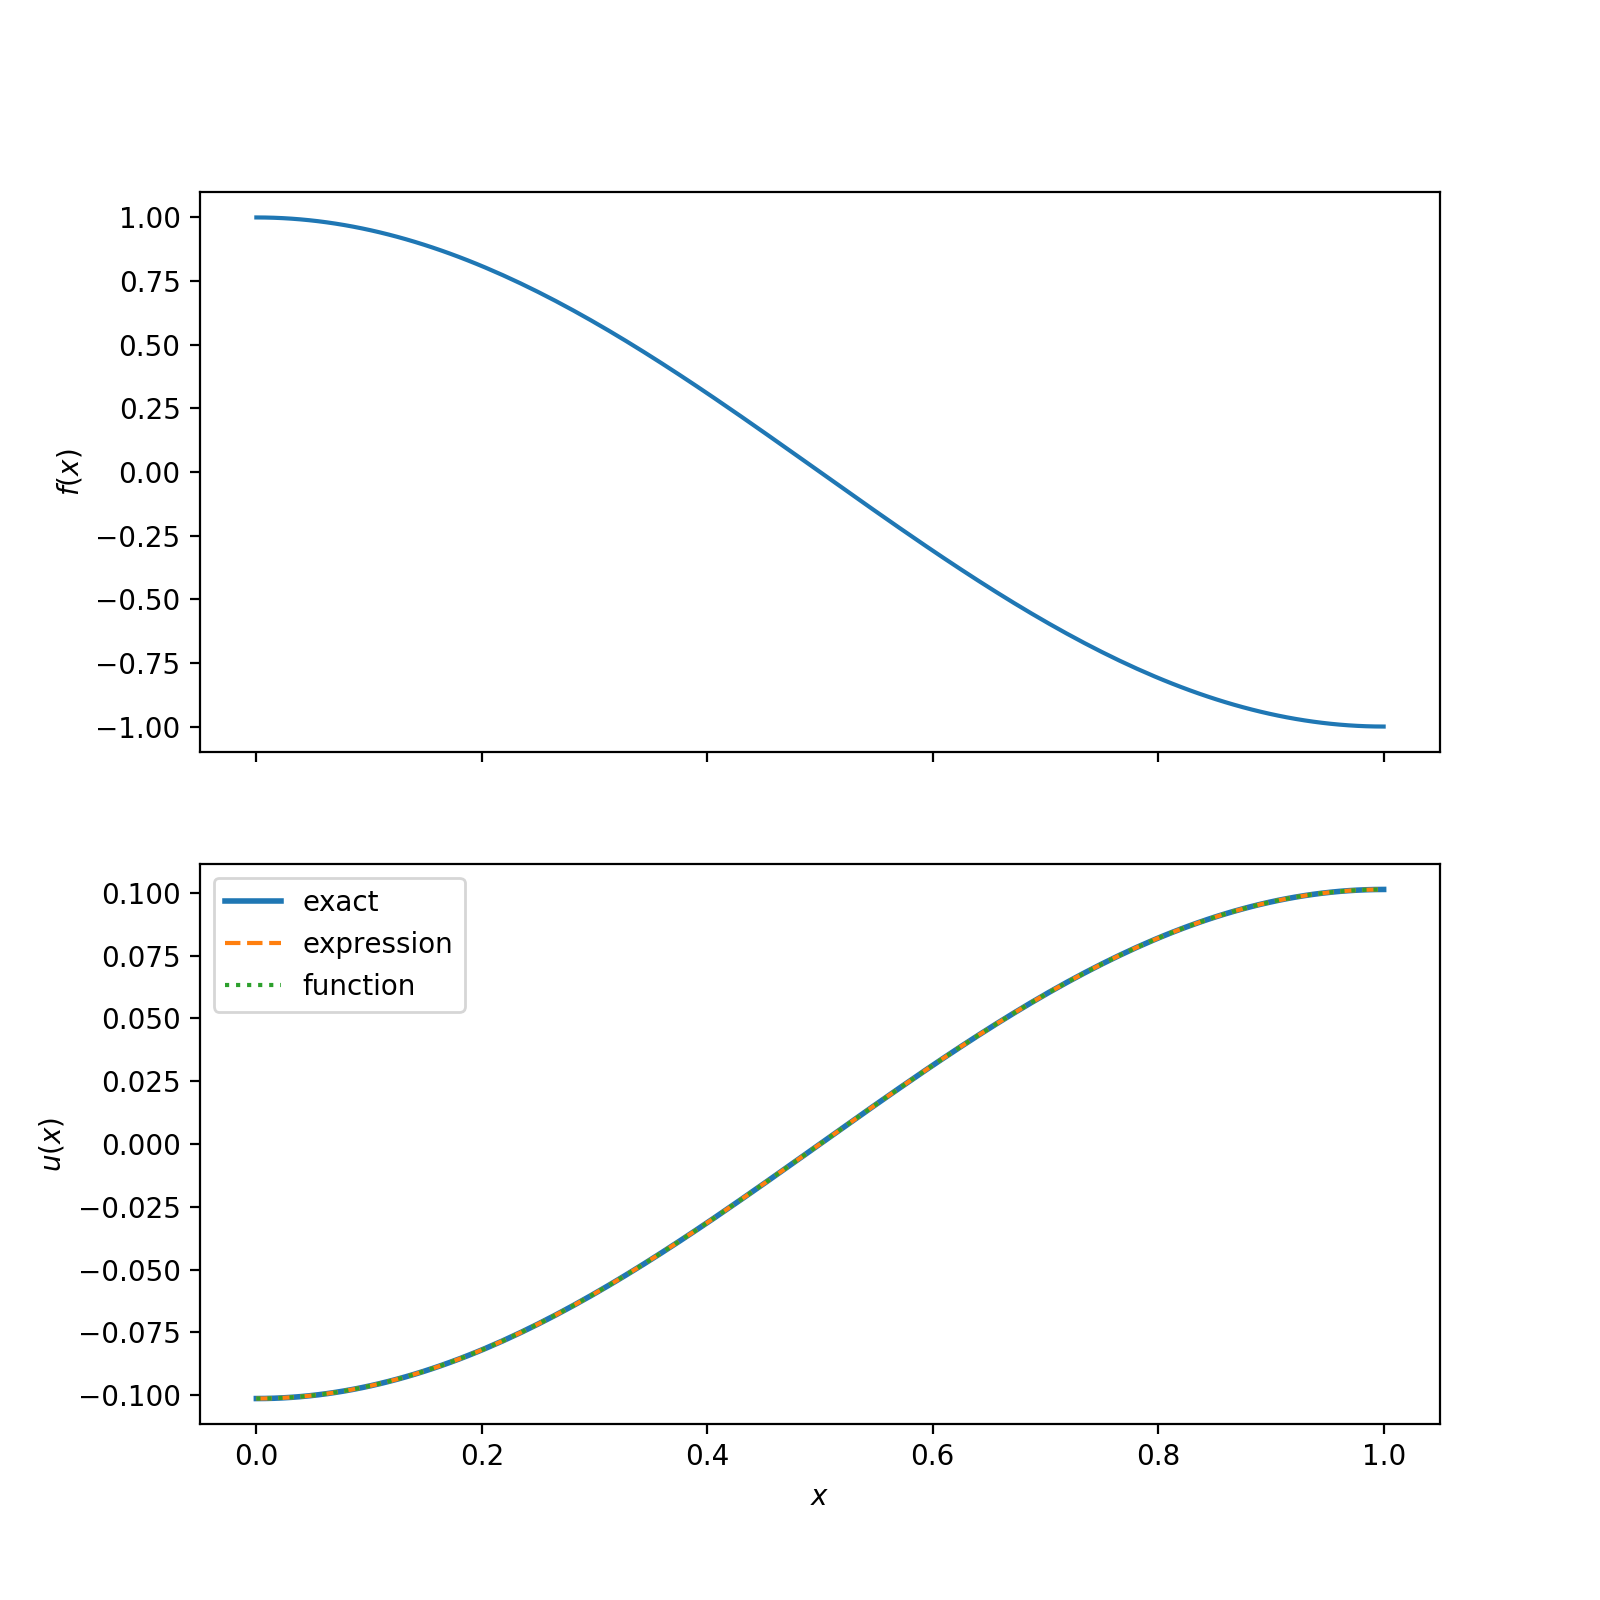

Text(0, 0.5, '$u(x)$')

In [6]:
# test plot
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
axes[0].plot(x, f)
axes[0].set_ylabel('$f(x)$')
axes[1].plot(x, u_, '-', lw=2, label='exact')
axes[1].plot(x, u0, '--', label='expression')
axes[1].plot(x, u1, ':', label='function')
axes[1].legend()
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$u(x)$')

## generate training/validation data 

In [7]:
n_samples = 10000 # number of training + validation samples
mesh_size = 64  # size of finite element mesh
x = np.linspace(0, 1, mesh_size+1) # mesh locations

# create n_samples sources (f(x)) as random normal distributed numbers convolved with a Gaussian
# to get a reasonably smooth signal
F = np.random.randn(n_samples, mesh_size+1, 1)
gaussian = ss.gaussian(11, std=2) # smoothing filter
for i in range(n_samples):
    F[i, :, 0] = np.convolve(F[i, :, 0], gaussian, 'same')

# normalize F to the interval [-1, 1]
F = F / abs(F).max()

# use dolfin to estimate u(x) for every f(x)
U = np.empty_like(F)
for i in range(n_samples):
    U[i, :, 0], x = poisson_w_hom_neumann_1D(mesh_size=mesh_size, f=F[i, :, 0])

In [8]:
F.shape, U.shape

((10000, 65, 1), (10000, 65, 1))

<IPython.core.display.Javascript object>


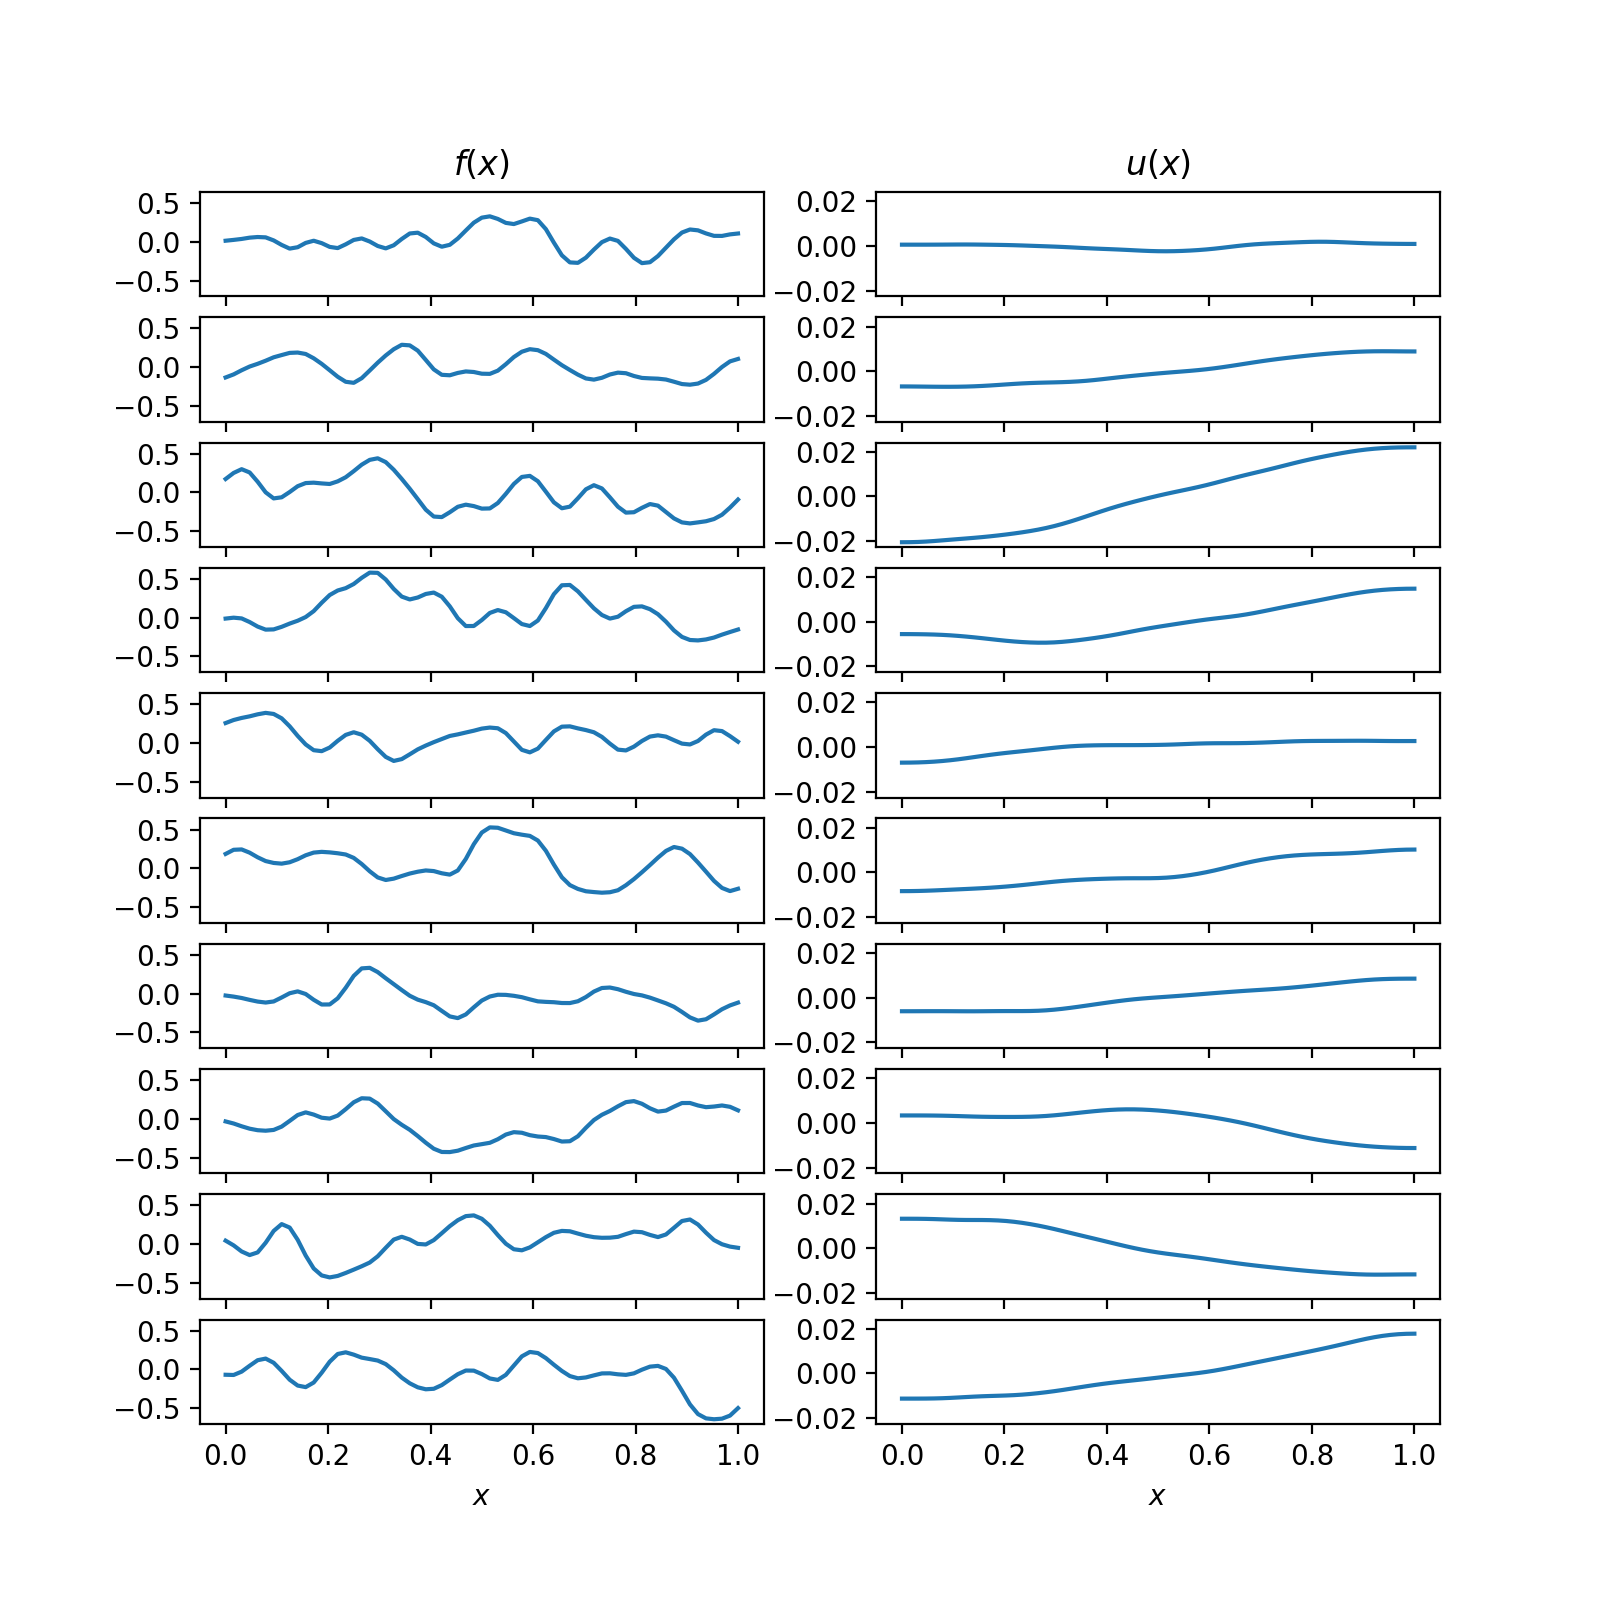

Text(0.5, 0, '$x$')

In [9]:
# plot some predictions of u(x) given input f(x)
fig, axes = plt.subplots(10, 2, sharey='col', sharex=True, figsize=(8, 8))
for i in range(10):
    axes[i, 0].plot(x, F[i,])
    axes[i, 1].plot(x, U[i,])
    if i == 0:
        axes[i, 0].set_title('$f(x)$')
        axes[i, 1].set_title('$u(x)$')
axes[i, 0].set_xlabel('$x$')
axes[i, 1].set_xlabel('$x$')

# Keras DNN implementation(s)

In [10]:
def generate_model(input_shape, filters=4, kernel_size=3, n_dense_1=1, lr=0.0001, clear_session=True):
    '''
    Parameters
    ----------
    input_shape: tuple
        input shape, length to tuple of ints
    filters: int
        number of filters in Conv1D layer
    kernel_size: int
        length of filters
    units: int
        number of units in Dense layer 
    lr: float
        learning rate for Adam optimizer
    clear_session: bool
        if True, clear keras backend
        
    Returns
    -------
    model: Model
        keras.Model instance
    '''
    if clear_session:
        keras.backend.clear_session()

    # input layer
    inputs = keras.layers.Input(shape=input_shape)
    
    # Conv1D layer 1
    x = keras.layers.Conv1D(filters, 
                            kernel_size=kernel_size, strides=1, 
                            padding='same',
                            kernel_initializer='uniform',
                            use_bias=True,
                            kernel_regularizer=l2(),
                            bias_regularizer=l2()
                           )(inputs)
    
    # Dense layer 1
    x = keras.layers.Dense(n_dense_1, activation='linear')(x)
    
    # Flattening layer
    x = keras.layers.Flatten()(x)
    
    # Output layer 
    outputs = keras.layers.Dense(input_shape[0], 
                                 activation='linear')(x)

    # Define model
    model = keras.models.Model(inputs=inputs, outputs=outputs)

    # Adam optimizer
    opt = keras.optimizers.Adam(lr=lr)
    
    # Compile model
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mse'])

    return model

In [11]:
# create model instance:
model = generate_model(input_shape=U[0].shape, 
                       filters=1, kernel_size=3, n_dense_1=1)

In [12]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 65, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 65, 1)             4         
_________________________________________________________________
dense_1 (Dense)              (None, 65, 1)             2         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 65)                4290      
Total params: 4,296
Trainable params: 4,296
Non-trainable params: 0
_________________________________________________________________


In [13]:
# train network, using 5% of data for validation
history = model.fit(F, U[:, :, 0], batch_size=50, epochs=50, validation_split=0.05)

Train on 9500 samples, validate on 500 samples
Epoch 1/50
9500/9500 [==============================] - 2s 213us/step - loss: 1.1181e-04 - mse: 9.9801e-05 - val_loss: 7.1445e-05 - val_mse: 6.2860e-05
Epoch 2/50
9500/9500 [==============================] - 1s 109us/step - loss: 6.3654e-05 - mse: 5.7134e-05 - val_loss: 5.8581e-05 - val_mse: 5.3931e-05
Epoch 3/50
9500/9500 [==============================] - 1s 91us/step - loss: 5.4641e-05 - mse: 5.1290e-05 - val_loss: 5.1808e-05 - val_mse: 4.9491e-05
Epoch 4/50
9500/9500 [==============================] - 1s 87us/step - loss: 4.8979e-05 - mse: 4.7232e-05 - val_loss: 4.6799e-05 - val_mse: 4.5456e-05
Epoch 5/50
9500/9500 [==============================] - 1s 86us/step - loss: 4.3925e-05 - mse: 4.2740e-05 - val_loss: 4.1404e-05 - val_mse: 4.0300e-05
Epoch 6/50
9500/9500 [==============================] - 1s 87us/step - loss: 3.8022e-05 - mse: 3.6874e-05 - val_loss: 3.4968e-05 - val_mse: 3.3773e-05
Epoch 7/50
9500/9500 [=======================

<IPython.core.display.Javascript object>


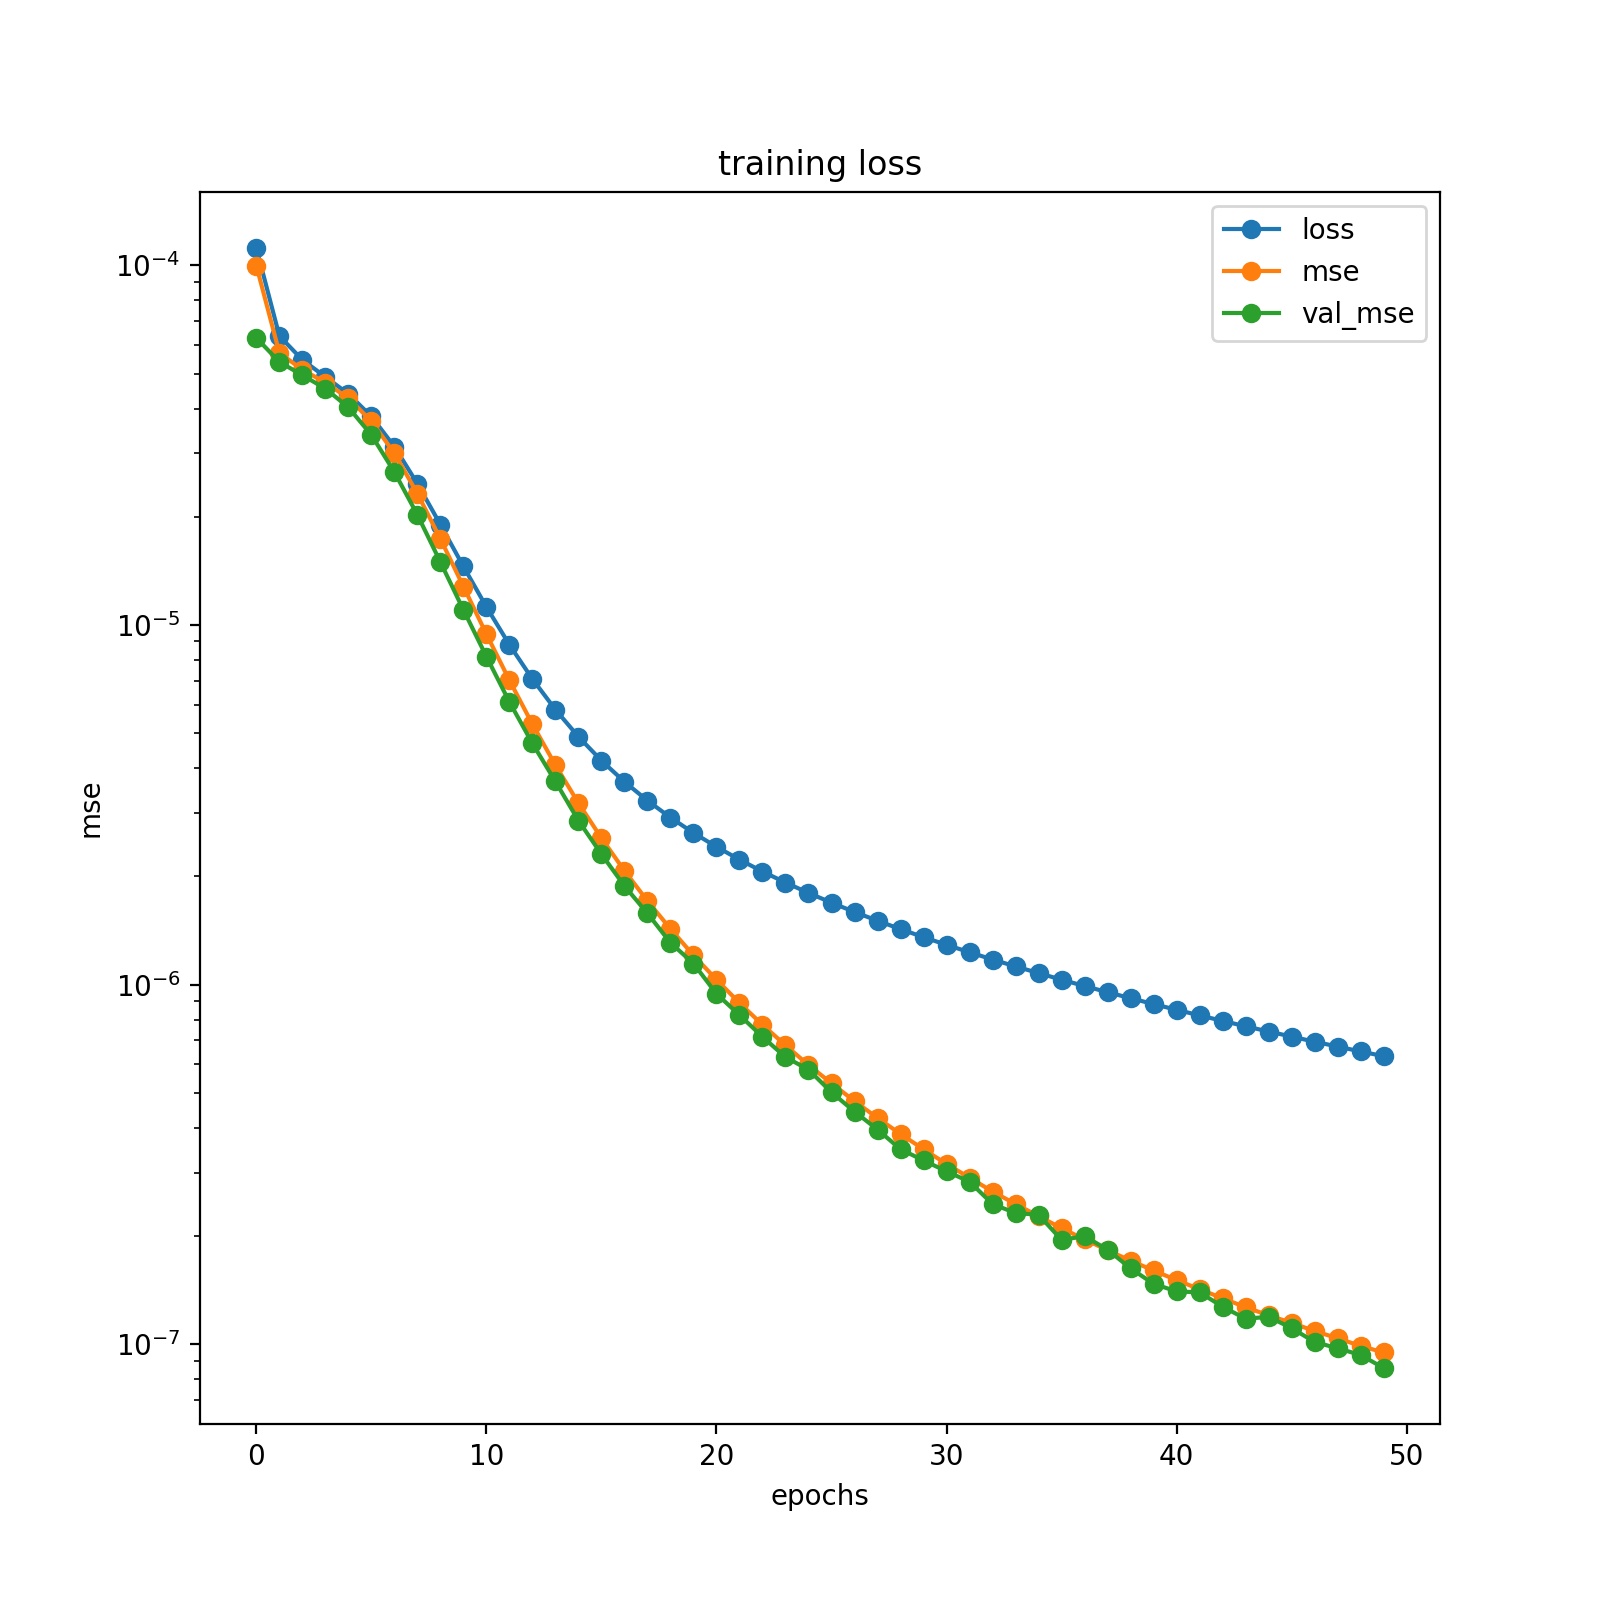

Text(0, 0.5, 'mse')

In [14]:
# training result
plt.figure(figsize=(8, 8))
plt.title('training loss')
plt.semilogy(history.history['loss'], '-o', label='loss')
plt.semilogy(history.history['mse'], '-o', label='mse')
plt.semilogy(history.history['val_mse'], '-o', label='val_mse')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('mse')

<IPython.core.display.Javascript object>


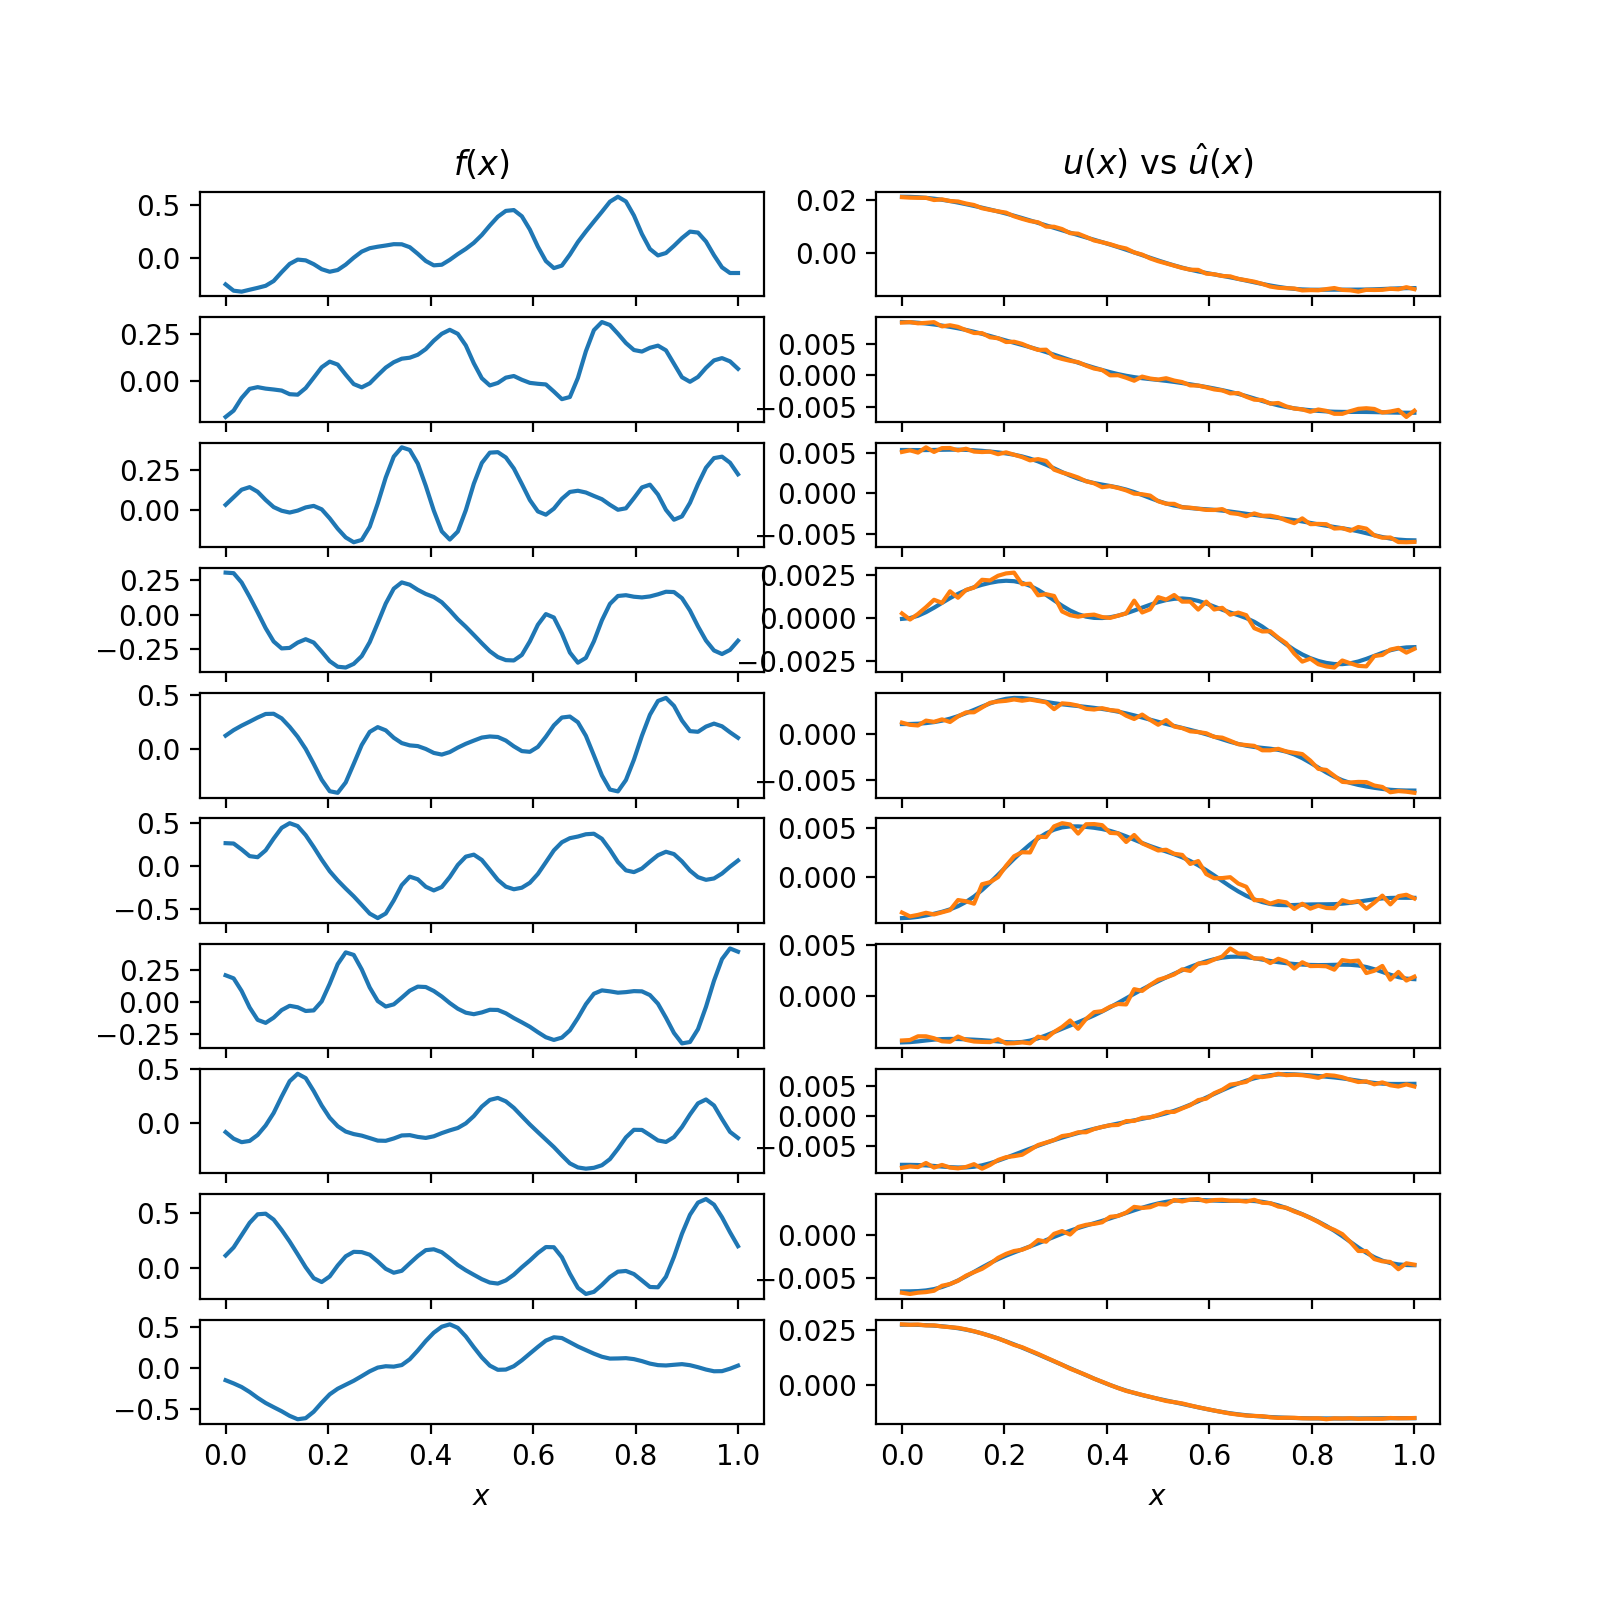

Text(0.5, 0, '$x$')

In [15]:
# visualize predictions on some samples from the validation set
n_val_samples = 10
F_val = history.validation_data[0][:n_val_samples]
U_val = history.validation_data[1][:n_val_samples]

U_pred = model.predict(F_val)

# compare prediction to ground truth
fig, axes = plt.subplots(n_val_samples, 2, figsize=(8, 8), sharex=True)
for i in range(n_val_samples):
    axes[i, 0].plot(x, F_val[i])
    axes[i, 1].plot(x, U_val[i].flatten())
    axes[i, 1].plot(x, U_pred[i].flatten())
    if i == 0:
        axes[i, 0].set_title('$f(x)$')
        axes[i, 1].set_title('$u(x)$ vs $\hat{u}(x)$')
axes[i, 0].set_xlabel('$x$')
axes[i, 1].set_xlabel('$x$')

<IPython.core.display.Javascript object>


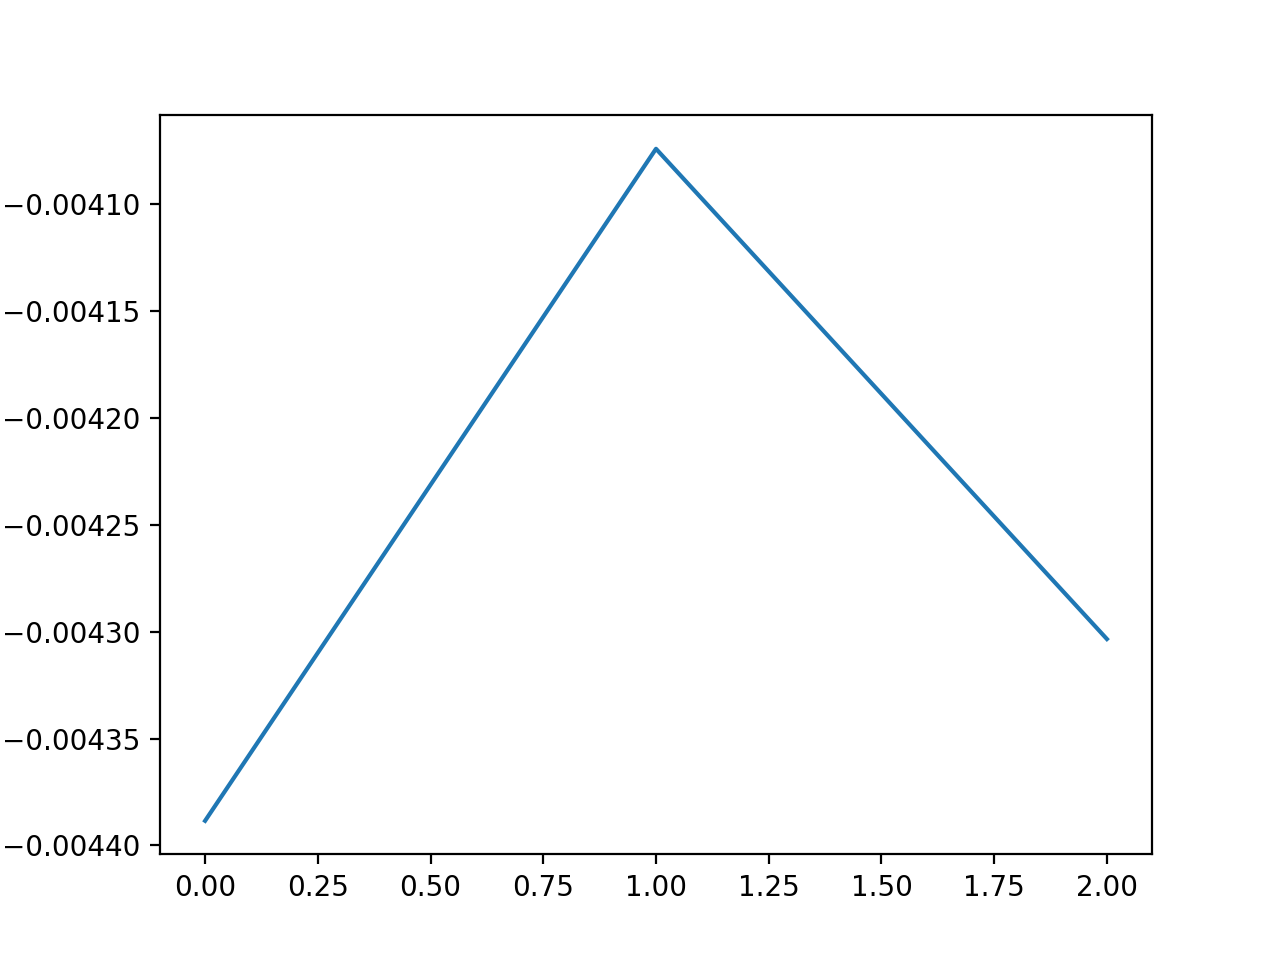

In [16]:
# draw weights from conv layer
w = np.squeeze(model.layers[1].get_weights()[0])
if w.ndim == 1:
    fig, ax = plt.subplots(1, 1)
    ax.plot(w)
else:
    fig, axes = plt.subplots(w.shape[0], 1, sharex=True, sharey=True)
    for i, ax in enumerate(axes):
        ax.plot(w[i])

# Accuracy vs. efficiency
Quantify the accuracy vs. # of degrees of freedom $N$ of the net, satisfying
$$
|| u - \hat{u}_N || \leq \alpha N^\beta
$$
and assess the parameters $\alpha$ and $\beta$. 

I'll define the # of degrees of freedom $N$
as the numbers of trainable parameters in each network, ignoring 
the definitions made by Gao & Jojic (2016) (arXiv:1603.09260). 

Further I'll quantify the CPU requirements
as the average time $T_\mathrm{eval}$ spent evaluating each input $f(x)$ on my
MacBook Pro (13-inch, 2016, 3.3 GHz Intel Core i7),
as function of $N^\gamma$. 

For the accuracy calculations I'll use $u(x)=cos(\pi x)$, so $f(x) = -\Delta u(x) = \pi^2 cos(\pi x) $

In [17]:
# number of neurons in layer dense_1
n_dense_1 = [1, 2, 4, 8, 16]

# exact solution to the Poisson problem
f_exact = -np.pi**2 * np.cos(np.pi * x) 
u_exact = np.cos(np.pi * x)

In [18]:
# train networks with different number of neurons in layer dense_1
models = []
for n in n_dense_1:
    models += [generate_model(input_shape=U[0].shape, 
                             filters=4, kernel_size=3, 
                             n_dense_1=n,
                             clear_session=False)]
    models[-1].summary()
    models[-1].fit(F, U[:, :, 0], batch_size=50, epochs=50, validation_split=0.05)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 65, 1)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 4)             16        
_________________________________________________________________
dense_3 (Dense)              (None, 65, 1)             5         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 65)                4290      
Total params: 4,311
Trainable params: 4,311
Non-trainable params: 0
_________________________________________________________________
Train on 9500 samples, validate on 500 samples
Epoch 1/50
9500/9500 [==============================] - 3s 314us/step - loss

Epoch 48/50
9500/9500 [==============================] - 1s 146us/step - loss: 3.9433e-07 - mse: 8.7884e-08 - val_loss: 3.8899e-07 - val_mse: 8.6037e-08
Epoch 49/50
9500/9500 [==============================] - 1s 142us/step - loss: 3.8396e-07 - mse: 8.4481e-08 - val_loss: 3.7888e-07 - val_mse: 8.2917e-08
Epoch 50/50
9500/9500 [==============================] - 1s 151us/step - loss: 3.7370e-07 - mse: 8.0933e-08 - val_loss: 3.7128e-07 - val_mse: 8.4563e-08
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 65, 1)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 4)             16        
_________________________________________________________________
dense_5 (Dense)              (None, 65, 2)             10        
______________________________________________________________

Epoch 45/50
9500/9500 [==============================] - 1s 154us/step - loss: 4.5875e-07 - mse: 5.9810e-08 - val_loss: 4.5092e-07 - val_mse: 5.9788e-08
Epoch 46/50
9500/9500 [==============================] - 2s 159us/step - loss: 4.4446e-07 - mse: 5.6816e-08 - val_loss: 4.3756e-07 - val_mse: 5.4379e-08
Epoch 47/50
9500/9500 [==============================] - 2s 162us/step - loss: 4.3147e-07 - mse: 5.4604e-08 - val_loss: 4.2649e-07 - val_mse: 5.1762e-08
Epoch 48/50
9500/9500 [==============================] - 1s 156us/step - loss: 4.1868e-07 - mse: 5.2134e-08 - val_loss: 4.1375e-07 - val_mse: 5.1351e-08
Epoch 49/50
9500/9500 [==============================] - 1s 157us/step - loss: 4.0725e-07 - mse: 5.0638e-08 - val_loss: 4.0143e-07 - val_mse: 4.8583e-08
Epoch 50/50
9500/9500 [==============================] - 1s 149us/step - loss: 3.9578e-07 - mse: 4.8642e-08 - val_loss: 3.9121e-07 - val_mse: 4.7148e-08
Model: "model_4"
_________________________________________________________________

Epoch 42/50
9500/9500 [==============================] - 2s 167us/step - loss: 4.4700e-07 - mse: 3.7225e-08 - val_loss: 4.3844e-07 - val_mse: 3.7372e-08
Epoch 43/50
9500/9500 [==============================] - 2s 167us/step - loss: 4.3167e-07 - mse: 3.5667e-08 - val_loss: 4.2749e-07 - val_mse: 4.6300e-08
Epoch 44/50
9500/9500 [==============================] - 1s 143us/step - loss: 4.1723e-07 - mse: 3.4303e-08 - val_loss: 4.0931e-07 - val_mse: 3.5208e-08
Epoch 45/50
9500/9500 [==============================] - 1s 136us/step - loss: 4.0397e-07 - mse: 3.3368e-08 - val_loss: 3.9633e-07 - val_mse: 3.1236e-08
Epoch 46/50
9500/9500 [==============================] - 1s 142us/step - loss: 3.9008e-07 - mse: 3.1196e-08 - val_loss: 3.8287e-07 - val_mse: 2.9996e-08
Epoch 47/50
9500/9500 [==============================] - 1s 140us/step - loss: 3.8026e-07 - mse: 3.2375e-08 - val_loss: 3.7275e-07 - val_mse: 3.2299e-08
Epoch 48/50
9500/9500 [==============================] - 1s 142us/step - loss: 3.6

Epoch 39/50
9500/9500 [==============================] - 2s 172us/step - loss: 4.3055e-07 - mse: 2.6886e-08 - val_loss: 4.2394e-07 - val_mse: 2.2622e-08
Epoch 40/50
9500/9500 [==============================] - 2s 164us/step - loss: 4.1487e-07 - mse: 2.5886e-08 - val_loss: 4.1175e-07 - val_mse: 2.1410e-08
Epoch 41/50
9500/9500 [==============================] - 2s 169us/step - loss: 3.9910e-07 - mse: 2.3826e-08 - val_loss: 3.9185e-07 - val_mse: 2.3968e-08
Epoch 42/50
9500/9500 [==============================] - 2s 164us/step - loss: 3.8493e-07 - mse: 2.2609e-08 - val_loss: 3.7822e-07 - val_mse: 2.4868e-08
Epoch 43/50
9500/9500 [==============================] - 2s 172us/step - loss: 3.7220e-07 - mse: 2.1978e-08 - val_loss: 3.6847e-07 - val_mse: 1.8614e-08
Epoch 44/50
9500/9500 [==============================] - 2s 175us/step - loss: 3.6121e-07 - mse: 2.2379e-08 - val_loss: 3.5598e-07 - val_mse: 2.7247e-08
Epoch 45/50
9500/9500 [==============================] - 2s 196us/step - loss: 3.4

Epoch 36/50
9500/9500 [==============================] - 2s 215us/step - loss: 3.3300e-07 - mse: 1.2981e-08 - val_loss: 3.2685e-07 - val_mse: 1.4474e-08
Epoch 37/50
9500/9500 [==============================] - 2s 212us/step - loss: 3.2146e-07 - mse: 1.1476e-08 - val_loss: 3.1603e-07 - val_mse: 1.2088e-08
Epoch 38/50
9500/9500 [==============================] - 2s 215us/step - loss: 3.1205e-07 - mse: 1.1341e-08 - val_loss: 3.0692e-07 - val_mse: 9.2945e-09
Epoch 39/50
9500/9500 [==============================] - 2s 215us/step - loss: 3.0300e-07 - mse: 1.1162e-08 - val_loss: 2.9828e-07 - val_mse: 1.3366e-08
Epoch 40/50
9500/9500 [==============================] - 2s 203us/step - loss: 2.9378e-07 - mse: 1.0252e-08 - val_loss: 2.8994e-07 - val_mse: 1.2702e-08
Epoch 41/50
9500/9500 [==============================] - 2s 211us/step - loss: 2.8622e-07 - mse: 1.0571e-08 - val_loss: 2.8200e-07 - val_mse: 7.6289e-09
Epoch 42/50
9500/9500 [==============================] - 2s 216us/step - loss: 2.7

In [19]:
# compute norms || u - \hat{u}_N ||, fetch N_params, and estimate time spent per evaluation
norms = [] # norms
N_params = [] # Degrees of freedom
T_eval = [] # average evaluation time
# containers for 1 and 100 samples of f_exact for predicting u(x)
f_1 = np.expand_dims(np.expand_dims(f_exact, 0), -1)
f_100 = np.expand_dims(np.array([f_exact] * 100), -1)
for i in range(len(models)):
    N_params += [models[i].count_params()]
    norms += [np.linalg.norm(u_exact - models[i].predict(f_1))]
    result = %timeit -o models[i].predict(f_1)
    T_eval += [result.average]

1.88 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.81 ms ± 40.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.14 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.94 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.32 ms ± 328 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<IPython.core.display.Javascript object>


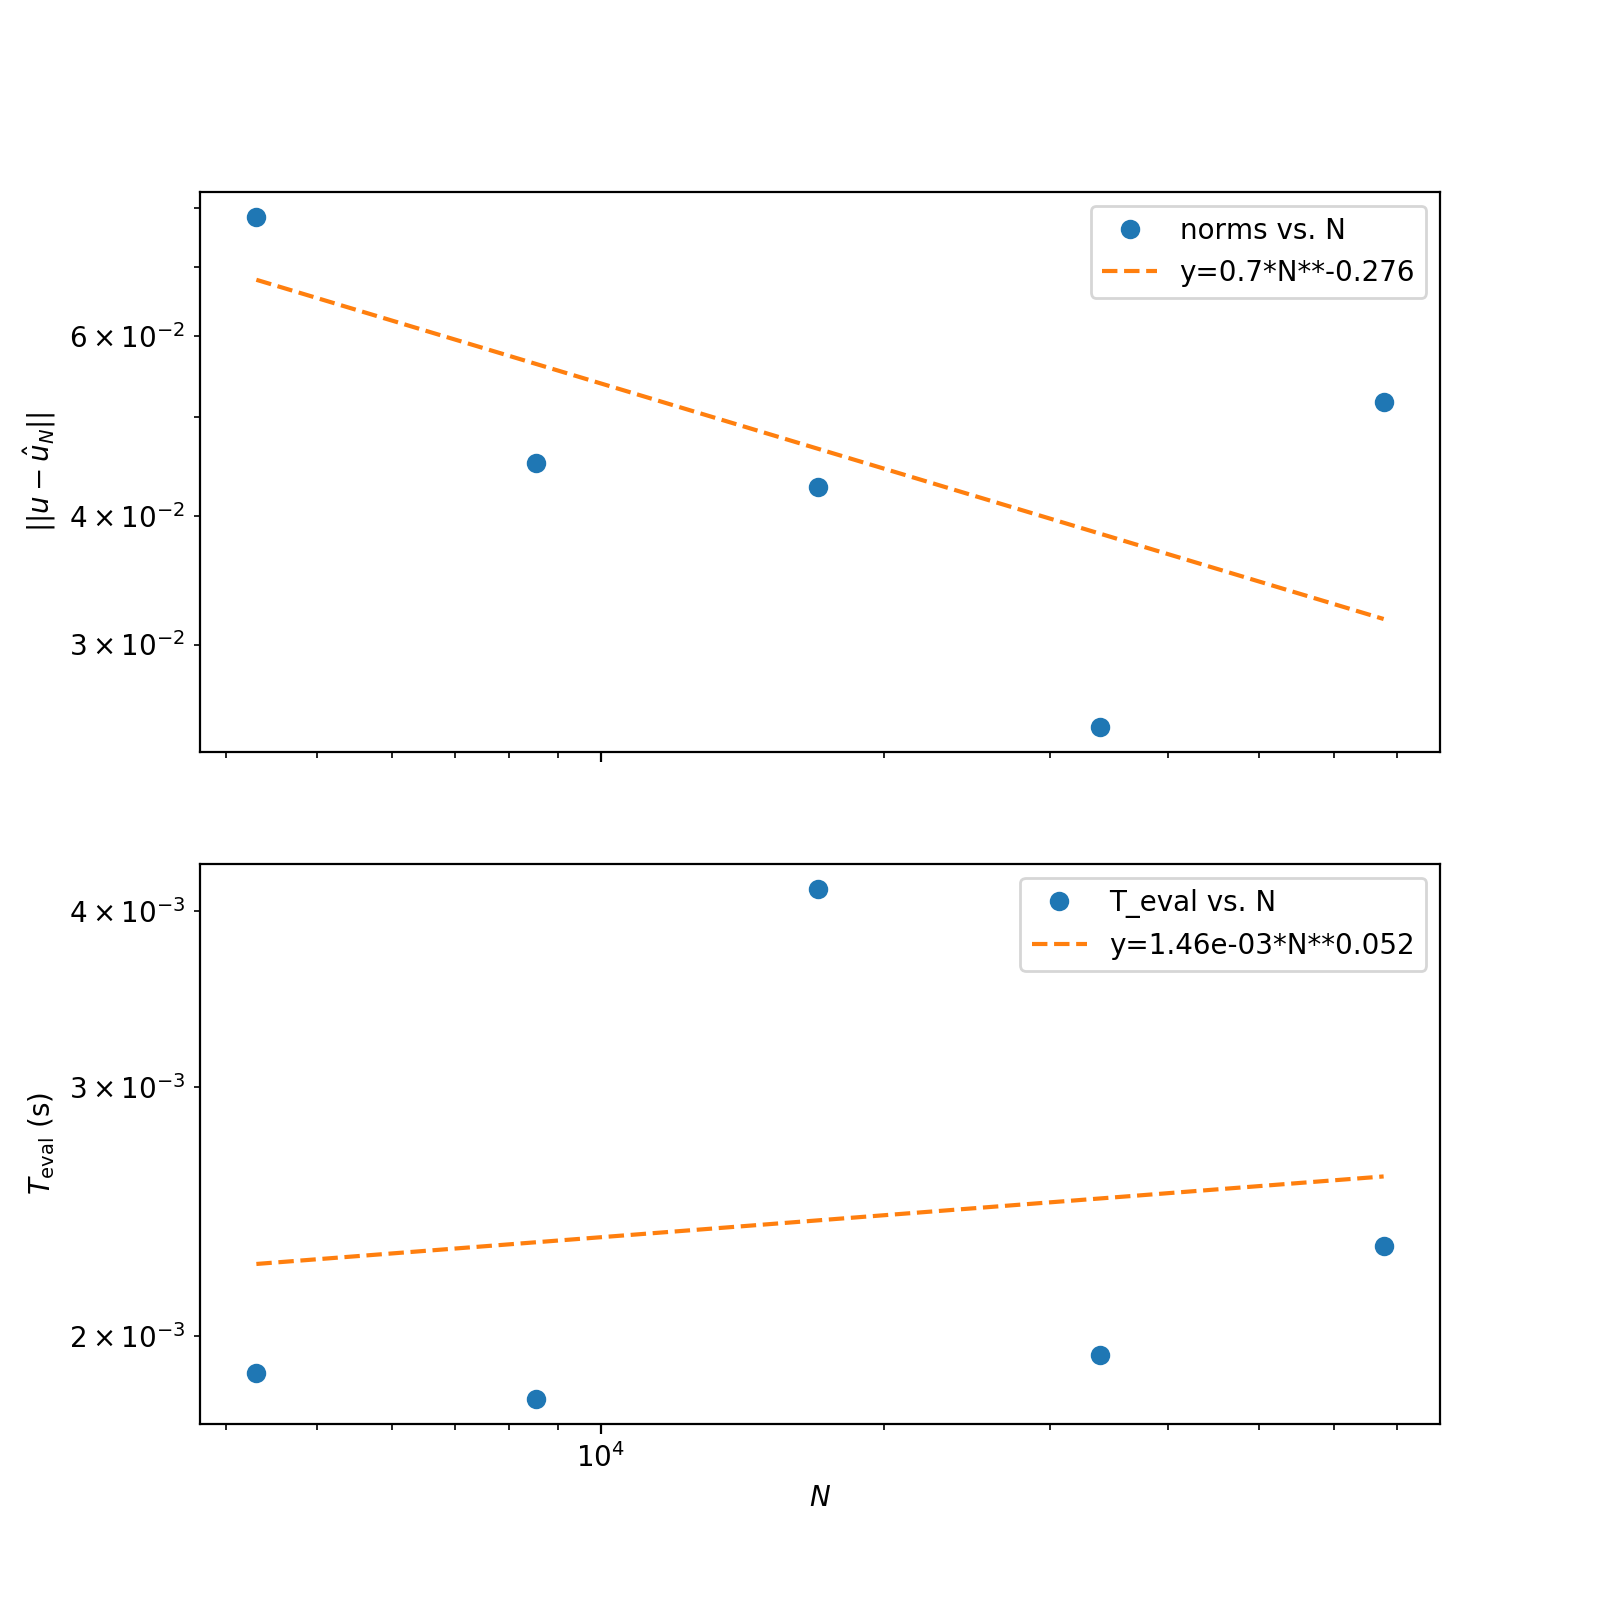

/Users/ehagen/anaconda3/envs/pytorch/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [20]:
# norms and CPU time as functions of N_params, and fit power law dependency on form y(N) = \alpha*N^\gamma

def func(N, y, alpha, gamma):
    '''power law function for fitting'''
    return alpha * N**gamma

fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
axes[0].loglog(N_params, norms, 'o', label='norms vs. N'), 
axes[0].set_ylabel('$||u - \hat{u}_N||$')
popt, pcov = so.curve_fit(func, N_params, norms)
axes[0].loglog(N_params, func(N_params, *popt), '--', label='y={:.1f}*N**{:.3f}'.format(popt[1], popt[2]))
axes[0].legend()

axes[1].loglog(N_params, T_eval, 'o', label='T_eval vs. N')
popt, pcov = so.curve_fit(func, N_params, T_eval)
axes[1].loglog(N_params, func(N_params, *popt), '--', label='y={:.2e}*N**{:.3f}'.format(popt[1], popt[2]))
axes[1].set_ylabel('$T_\mathrm{eval}$ (s)')
axes[1].set_xlabel('$N$')
axes[1].legend()